In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

%pip install kaggle
import os
import json

# Define the path for the kaggle.json file
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_file = os.path.join(kaggle_dir, 'kaggle.json')

# Create the .kaggle directory if it doesn't exist
os.makedirs(kaggle_dir, exist_ok=True)

# Create a dummy kaggle.json file with placeholder values
# This file needs to be replaced by the actual kaggle.json file uploaded by the user
dummy_credentials = {
    "username": "...",
    "key": "ae443c5436ee2ac05b6bb21d23e45b75"
}

with open(kaggle_file, 'w') as f:
    json.dump(dummy_credentials, f)

# Set the permissions for the kaggle.json file
os.chmod(kaggle_file, 0o600)

!kaggle datasets download -d orvile/gastric-cancer-histopathology-tissue-image-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 2.97G/3.03G [00:18<00:05, 10.3MB/s]
100% 3.03G/3.03G [00:18<00:00, 173MB/s] 


In [4]:
import os
import cv2
import numpy as np # Import numpy

image_dir = '/content/HMU-GC-HE-30K/all_image'
images = []
labels = []

# Assuming subdirectories within HMU-GC-HE-30K represent the labels
categories = os.listdir(image_dir)
counter = 0;
for category in categories:
    category_path = os.path.join(image_dir, category)
    if (os.path.isdir(category_path)):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            try:
                img = cv2.imread(image_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224)) # Resize image to 224x224 - not technically required but safe
                    #img = img / 255.0  # Don't normalize pixel values
                    images.append(img)
                    labels.append(category)
                    counter=counter+1
                    if (counter % 1000 == 0): # Increased print frequency for large dataset
                        print(f"Loaded {counter} images.")
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

print(f"Loaded {len(images)} images with {len(labels)} labels.")

# Convert images list to numpy array
images = np.array(images)
print (images[0].shape)
print (labels[0])

Loaded 1000 images.
Loaded 2000 images.
Loaded 3000 images.
Loaded 4000 images.
Loaded 5000 images.
Loaded 6000 images.
Loaded 7000 images.
Loaded 8000 images.
Loaded 9000 images.
Loaded 10000 images.
Loaded 11000 images.
Loaded 12000 images.
Loaded 13000 images.
Loaded 14000 images.
Loaded 15000 images.
Loaded 16000 images.
Loaded 17000 images.
Loaded 18000 images.
Loaded 19000 images.
Loaded 20000 images.
Loaded 21000 images.
Loaded 22000 images.
Loaded 23000 images.
Loaded 24000 images.
Loaded 25000 images.
Loaded 26000 images.
Loaded 27000 images.
Loaded 28000 images.
Loaded 29000 images.
Loaded 30000 images.
Loaded 31000 images.
Loaded 31096 images with 31096 labels.
(224, 224, 3)
MUC


In [5]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np

# Convert labels to numerical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(np.unique(labels_encoded))
print(f"Number of distinct labels: {num_classes}")


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)


Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

Number of distinct labels: 8


In [6]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam # Import Adam optimizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Load the EfficientNetB0 base model
# Make sure to set include_top=False to remove the classification head
base_model_sequential = EfficientNetB0(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# Optionally, freeze the base model layers
base_model_sequential.trainable = False # Set to False to freeze the base model


# Create a Sequential model
model_sequential = models.Sequential([
    # Add the data augmentation layer if you want to use it
    # data_augmentation, # Uncomment this line if you defined data_augmentation

    # Add the EfficientNet base model as a layer
    base_model_sequential,

    # Add your custom classification layers
    layers.GlobalAveragePooling2D(), # This will output a 1280-feature vector for EfficientNetB0
    layers.Dropout(0.3), # Dropout for regularization
    layers.Dense(num_classes, activation='softmax') # Linear mapping from 1280 features to num_classes (8) outputs
])

# Compile the model
model_sequential.compile(optimizer=Adam(learning_rate=0.001,
                                        weight_decay=0.0001), # Added Adam optimizer with weight_decay
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

model_sequential.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:

history = model_sequential.fit(X_train, Y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.4494 - loss: 1.4612 - val_accuracy: 0.5758 - val_loss: 1.1267
Epoch 2/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5761 - loss: 1.1341 - val_accuracy: 0.5844 - val_loss: 1.0889
Epoch 3/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5896 - loss: 1.0825 - val_accuracy: 0.5961 - val_loss: 1.0677
Epoch 4/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6007 - loss: 1.0525 - val_accuracy: 0.6087 - val_loss: 1.0424
Epoch 5/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6046 - loss: 1.0425 - val_accuracy: 0.5987 - val_loss: 1.0469
Epoch 6/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6106 - loss: 1.0288 - val_accuracy: 0.6029 - val_loss: 1.0342
Epoch 7/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6113 - loss: 1.0231 - val_accuracy: 0.6047 - val_loss: 1.0263
Epoch 8/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6118 - loss: 1.0239 - 

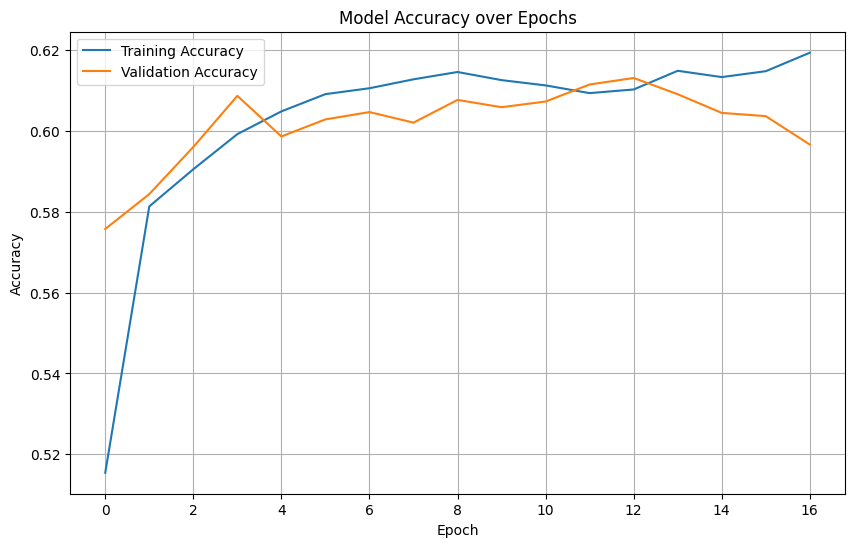

195/195 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.6156 - loss: 1.0087
Test Loss: 0.9920
Test Accuracy: 0.6243


In [8]:

def plot_accuracy(history):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_accuracy(history)

# Evaluate the model on the test set
loss, accuracy = model_sequential.evaluate(X_test, Y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the model
y_pred_probs = model_sequential.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test back to single integer labels for confusion matrix
y_true_classes = np.argmax(Y_test, axis=1)

print("Predictions generated and labels prepared.")

195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step
Predictions generated and labels prepared.


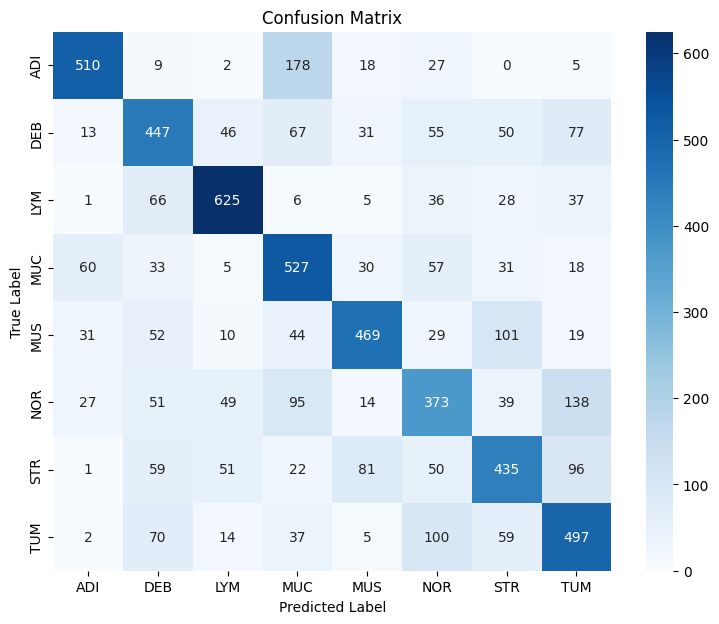

In [10]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
# Define gastric cancer class names
gc_class_names = [
    'ADI',
    'DEB',
    'LYM',
    'MUC',
    'MUS',
    'NOR',
    'STR',
    'TUM',
]

# Define class names (assuming CIFAR-10 classes)
class_names = gc_class_names # Use actual CIFAR-10 class names

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

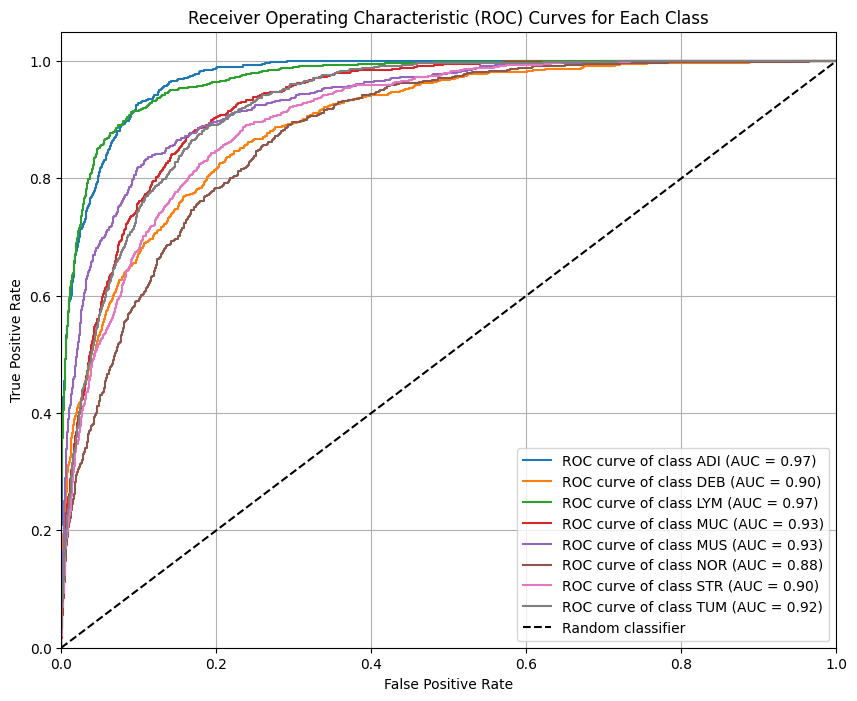

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Number of classes
num_classes = Y_test.shape[1]

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(Y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()